In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Для построения графиков, привязанных к дате и времени с помощью matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

376

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 1992-01-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   S4248SM144NCEN  376 non-null    int64
dtypes: int64(1)
memory usage: 5.9 KB


In [4]:

df.dropna(inplace=True)
len(df)

376

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,S4248SM144NCEN
DATE,
2022-12-01,18001
2023-01-01,12201
2023-02-01,13552
2023-03-01,16041
2023-04-01,14574


In [7]:
df['S4248SM144NCEN'].head()

DATE
1992-01-01    3459
1992-02-01    3458
1992-03-01    4002
1992-04-01    4564
1992-05-01    4221
Name: S4248SM144NCEN, dtype: int64

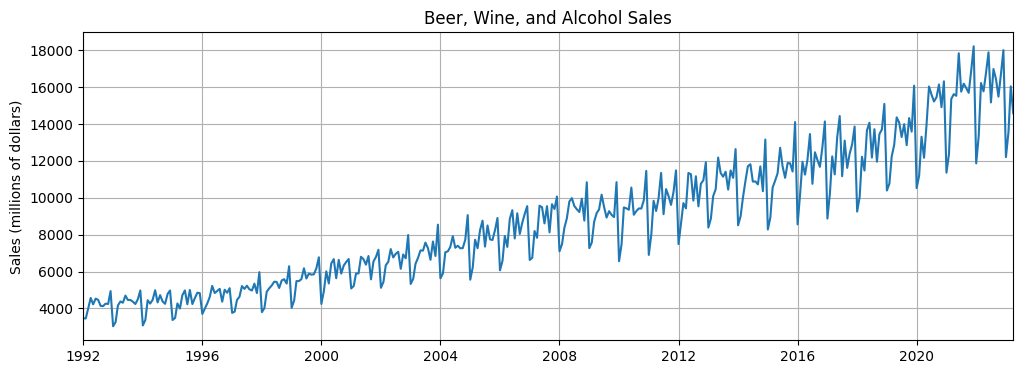

In [8]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [9]:
# Извлечь значения из исходного файла .csv
y = df['S4248SM144NCEN'].values.astype(float)

# определить размер тестового набора
test_size = 12

# Создааем обучающий и тестовый наборы
train_set = y[:-test_size]
test_set = y[-test_size:]

In [10]:
test_set

array([16755., 17882., 15168., 16977., 16430., 15480., 16718., 18001.,
       12201., 13552., 16041., 14574.])

In [11]:
from sklearn.preprocessing import MinMaxScaler

#
scaler = MinMaxScaler(feature_range=(-1, 1))

In [12]:
# нормализуем обучающее множество
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [13]:
train_norm.min()

-1.0

In [14]:
train_norm.max()

1.0

In [15]:
train_norm.mean()

-0.2731181861616645

In [16]:
type(train_norm)

numpy.ndarray

In [17]:
# Конвертируем train_norm из массива в тензор
train_norm = torch.FloatTensor(train_norm).view(-1)

# размер окна
window_size = 12

# Функция для создания обучающих примеров seq/label
def input_data(seq,ws):  # ws -- размер окна
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Применяем функцию для input_data  и получаем нормализованный набор для обучения: train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  #

352

In [18]:
# Отобразим первый seq/label элемент из train_data
train_data[4]

(tensor([-0.8432, -0.8026, -0.8109, -0.8543, -0.8557, -0.8382, -0.8407, -0.7490,
         -1.0000, -0.9697, -0.8513, -0.8227]),
 tensor([-0.8319]))

In [19]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Добавляем LSTM слой:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Добавляем полносвязный слой:
        self.linear = nn.Linear(hidden_size,output_size)

        # Инициализируем h0 и c0:
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # нам нужно только последнее значение

In [20]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):

    # извлекаем последовательность и метки из обучающего множества
    for seq, y_train in train_data:

        # сбрасываем параметры и скрытые состояния
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # выводим результат обучения
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00232654
Epoch:  2 Loss: 0.00194766
Epoch:  3 Loss: 0.00366904
Epoch:  4 Loss: 0.00021658
Epoch:  5 Loss: 0.00017786
Epoch:  6 Loss: 0.00174227
Epoch:  7 Loss: 0.00370159
Epoch:  8 Loss: 0.00570333
Epoch:  9 Loss: 0.00618198
Epoch: 10 Loss: 0.00553098
Epoch: 11 Loss: 0.00485414
Epoch: 12 Loss: 0.00620992
Epoch: 13 Loss: 0.00841003
Epoch: 14 Loss: 0.00912133
Epoch: 15 Loss: 0.01001738
Epoch: 16 Loss: 0.01110688
Epoch: 17 Loss: 0.01094197
Epoch: 18 Loss: 0.01214967
Epoch: 19 Loss: 0.01212068
Epoch: 20 Loss: 0.01148895
Epoch: 21 Loss: 0.01177080
Epoch: 22 Loss: 0.01117636
Epoch: 23 Loss: 0.01480948
Epoch: 24 Loss: 0.00888899
Epoch: 25 Loss: 0.01075705
Epoch: 26 Loss: 0.00833890
Epoch: 27 Loss: 0.00493693
Epoch: 28 Loss: 0.00000000
Epoch: 29 Loss: 0.00599297
Epoch: 30 Loss: 0.00036252
Epoch: 31 Loss: 0.00085718
Epoch: 32 Loss: 0.00283998
Epoch: 33 Loss: 0.00123005
Epoch: 34 Loss: 0.00405553
Epoch: 35 Loss: 0.00013592
Epoch: 36 Loss: 0.00067300
Epoch: 37 Loss: 0.00071637
E

In [22]:
future = 12

# Добавляем последнее окно значений обучения в список прогнозов.
preds = train_norm[-window_size:].tolist()

# Установим модель в режим оценки
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [23]:
# Выводим значения предсказаний
preds[window_size:]    # то же самое что preds[-future:]

[0.6300826072692871,
 0.7736758589744568,
 0.6631851196289062,
 0.6441038846969604,
 0.6394173502922058,
 0.6360856294631958,
 0.7127183675765991,
 0.8751523494720459,
 0.3743644952774048,
 0.569152295589447,
 0.7034185528755188,
 0.6482897996902466]

In [24]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[15403.32698917],
       [16493.19976962],
       [15654.57505798],
       [15509.74848485],
       [15474.17768872],
       [15448.88992763],
       [16030.53240991],
       [17263.40633249],
       [13462.42651916],
       [14940.86592352],
       [15959.94681633],
       [15541.51957965]])

In [25]:
df['S4248SM144NCEN'][-12:]

DATE
2022-05-01    16755
2022-06-01    17882
2022-07-01    15168
2022-08-01    16977
2022-09-01    16430
2022-10-01    15480
2022-11-01    16718
2022-12-01    18001
2023-01-01    12201
2023-02-01    13552
2023-03-01    16041
2023-04-01    14574
Name: S4248SM144NCEN, dtype: int64

In [26]:
#
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

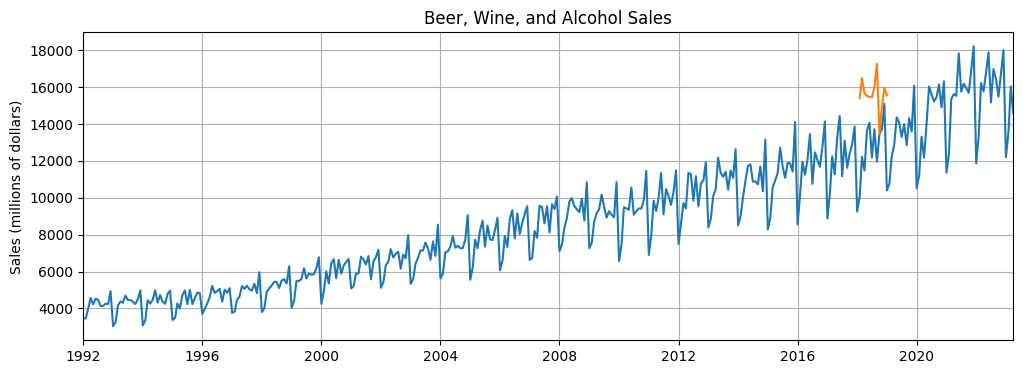

In [27]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

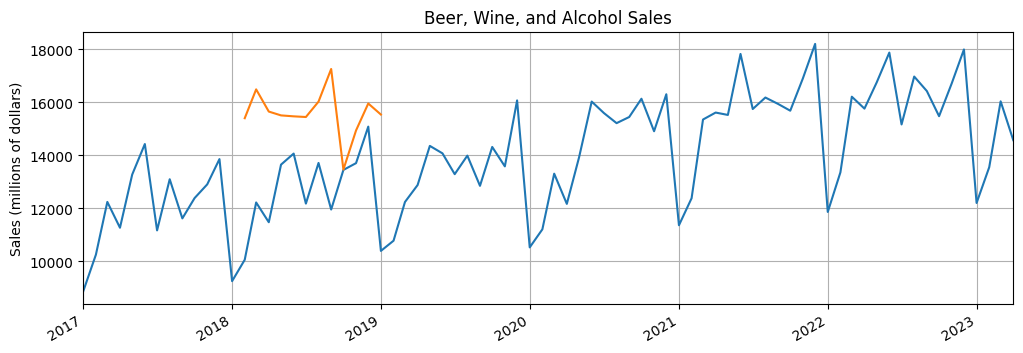

In [28]:
# рисуем хвост графика
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

#
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [29]:
epochs = 100

# вернем модель в режим обучения
model.train()

# масштабируем весь датасет
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):

    # тренируем на всем датасете
    for seq, y_train in all_data:

        # сброс параметров
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # выводим результат
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00601536
Epoch:  2 Loss: 0.04834149
Epoch:  3 Loss: 0.02212632
Epoch:  4 Loss: 0.01130272
Epoch:  5 Loss: 0.00133727
Epoch:  6 Loss: 0.00059938
Epoch:  7 Loss: 0.03119920
Epoch:  8 Loss: 0.02492732
Epoch:  9 Loss: 0.01865904
Epoch: 10 Loss: 0.01308904
Epoch: 11 Loss: 0.01982607
Epoch: 12 Loss: 0.02310020
Epoch: 13 Loss: 0.01413117
Epoch: 14 Loss: 0.01425911
Epoch: 15 Loss: 0.01266380
Epoch: 16 Loss: 0.00960222
Epoch: 17 Loss: 0.01446288
Epoch: 18 Loss: 0.01204036
Epoch: 19 Loss: 0.01348145
Epoch: 20 Loss: 0.01301886
Epoch: 21 Loss: 0.01380460
Epoch: 22 Loss: 0.00905489
Epoch: 23 Loss: 0.00777249
Epoch: 24 Loss: 0.01881166
Epoch: 25 Loss: 0.01480801
Epoch: 26 Loss: 0.01171215
Epoch: 27 Loss: 0.00967229
Epoch: 28 Loss: 0.03032264
Epoch: 29 Loss: 0.01369077
Epoch: 30 Loss: 0.01138387
Epoch: 31 Loss: 0.01215009
Epoch: 32 Loss: 0.01291343
Epoch: 33 Loss: 0.02012705
Epoch: 34 Loss: 0.01214975
Epoch: 35 Loss: 0.01808356
Epoch: 36 Loss: 0.00861797
Epoch: 37 Loss: 0.01959214
E

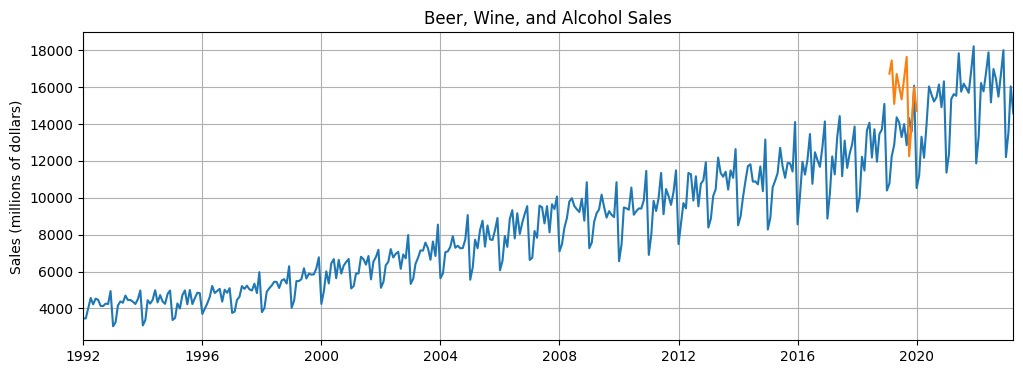

In [30]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # сбрасываем параметры
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

# обращение нормализации
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# Вывод графиков
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

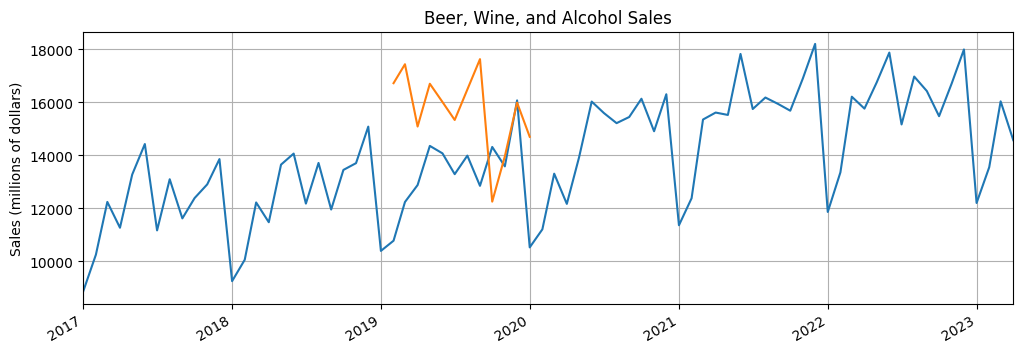

In [31]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()